# DESAFIO - Aula_19: Algoritmos de Classificação: Regressão logística

Base de Dados <br>
Link: https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv <br>
Resumo: O conjunto de dados está relacionado a campanhas de marketing direto (chamadas telefônicas) de uma instituição bancária portuguesa. A variável resposta (y) é binária e indica se o cliente subscreveu um depósito a prazo (1-Sim, 0-Não). <br>
Objetivo: Ajustar um modelo de regressão logística, em uma base de treinamento, para a resposta binária, fazer a previsão desta resposta e avaliar a qualidade de ajuste do modelo em uma base de teste.


## Importando os Dados

In [63]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [64]:
data = pd.read_csv('C:/Users/crrodr/Documents/1. Conhecimento/Tera - Data Science/TURMA_2_201803/Reg_Logistica/Exemplo_Exercicio/bank/banking.csv',header=0)

#drop na
data = data.dropna()
lista = ('age','education','contact','month','day_of_week','duration',
        'campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx', 
        'euribor3m','nr_employed')
#exclui algumas variáveis da análise
for col in lista:
    data.drop(col, axis=1, inplace=True)
    
print(data.shape)

(41188, 7)


O conjunto de dados fornece a informação dos clientes do banco. Inclui ________ registros e __________ variáveis.

In [65]:
data.head()

,job,marital,default,housing,loan,poutcome,y
0,blue-collar,married,unknown,yes,no,nonexistent,0
1,technician,married,no,no,no,nonexistent,0
2,management,single,no,yes,no,success,1
3,services,married,no,no,no,nonexistent,0
4,retired,married,no,yes,no,success,1


# Parte_1A: Analisando as Variáveis Input - Missing/Categóricas

- ## Var resposta

Transformando a variável Income-Renda em 0's and 1's

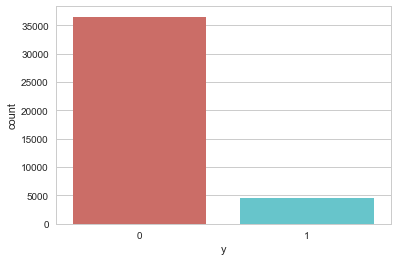

In [66]:
# grafico de barras para a variável dependente
sns.countplot(x='y',data=data, palette='hls')
plt.show()

A proporção de 1's é de aproximandamente 14%

- ## Verificando valores missing

In [67]:
# verificando quantidade de missing para cada var
data.isnull().sum()

job         0
marital     0
default     0
housing     0
loan        0
poutcome    0
y           0
dtype: int64

Não há dados missing na base de análise

- ## job: trabalho do cliente

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

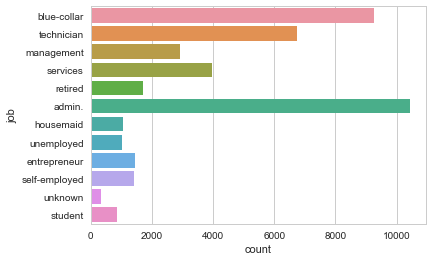

In [68]:
# grafico de barras para a variável customer job 
sns.countplot(y='job',data=data)
plt.show()
#há muitas categorias: vamos agrupar as classes que tem menos obs

In [69]:
# unindo as categorias de trabalho, para depois não criar muitas dummys
def agrupa(job):
    if job in ['blue-collar']:
        return 'blue_collar'
    elif job in ['technician']:
        return 'technician'
    elif job in ['admin.']:
        return 'admin' 
    elif job in ['management']:
        return 'management'
    elif job in ['services']:
        return 'services'
    
    else: 
        return 'other'    

In [70]:
data['job'] = data['job'].apply(agrupa)

- ## Marital: estado civil

A categoria unknown tem poucas obs - vamos juntá-la com a cat divorced

In [71]:
def agrupa1(marital):
    if marital in ['unknown']:
        return 'divorced'
    else: 
        return marital   

In [72]:
data['marital'] = data['marital'].apply(agrupa1)

- ## Default - crédito em default

A categoria yes tem poucas obs - vamos juntá-la com a cat unknown

In [73]:
def agrupa2(default):
    if default in ['yes']:
        return 'unknown'
    else: 
        return default   

In [74]:
data['default'] = data['default'].apply(agrupa2)

## Parte_1B: Criando Dummys

Crie variáveis dummy, que são variáveis com apenas dois valores, zero e um. <br>
Nos modelos de regressão logística, a codificação de todas as variáveis independentes-categoricas como variáveis dummy permite uma fácil interpretação e cálculo da odds ratios e aumenta a estabilidade e a importância dos coeficientes.

In [75]:
data.dtypes

job         object
marital     object
default     object
housing     object
loan        object
poutcome    object
y            int64
dtype: object

In [76]:
#list of columns with dtype: object
#axes[1] coluna
#axes[0] linha
categorical_features = data.select_dtypes(include=['object']).axes[1] # retorna as vars que são do tipo objeto

# unique: retorna os valores únicos
# nunique: retorna o número de valores únicos
for col in categorical_features:
    print (col, data[col].nunique()) # retorna as vars que são do tipo objeto e a quantidade de categorias em cada uma delas

job 6
marital 3
default 2
housing 3
loan 3
poutcome 3


In [77]:
#criando dummys para as variáveis categoricas
for col in categorical_features:
    data = pd.concat([data, pd.get_dummies(data[col], prefix=col, prefix_sep='_')], axis=1)
    data.drop(col, axis=1, inplace=True)

In [78]:
data.columns

Index(['y', 'job_admin', 'job_blue_collar', 'job_management', 'job_other',
       'job_services', 'job_technician', 'marital_divorced', 'marital_married',
       'marital_single', 'default_no', 'default_unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [79]:
data.head()

,y,job_admin,job_blue_collar,job_management,job_other,job_services,job_technician,marital_divorced,marital_married,marital_single,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1


## Parte_1C: Verificando a correlação entre as variáveis input

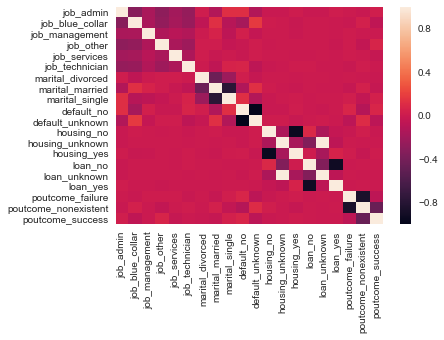

In [80]:
data1 = data.drop('y', axis=1)
sns.heatmap(data1.corr())
plt.show()

As variáveis input não aparentam alta correlação, desta maneira podemos seguir com todas as variáveis para a análise

## Parte_2: Dividindo a base em train e test

In [81]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [82]:
print(X_train.shape, X_test.shape)

(32950, 20) (8238, 20)


## Parte_3: Metodo de seleção de variáveis forward

In [83]:
#Metodo de seleção de variáveis forward usando statsmodels
import statsmodels.formula.api as smf
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [84]:
#junta as bases para utilizar dentro da função forward_selected
X1 = pd.concat([X_train,y_train], axis=1)
X1.rename(columns={'y':'Income'}, inplace=True)
X1.head()

,job_admin,job_blue_collar,job_management,job_other,job_services,job_technician,marital_divorced,marital_married,marital_single,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success,Income
31098,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0
20399,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0
8259,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0
17599,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0
38003,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0


In [85]:
#colocar para rodar quando for sair para o almoço
#aplicando o método de seleção de variáveis forward

model = forward_selected(X1, 'Income')
print(model.model.formula)
print(model.rsquared_adj)


Income ~ poutcome_success + default_unknown + job_other + poutcome_nonexistent + marital_single + job_admin + job_technician + job_management + housing_no + default_no + 1
0.112932094354


## Parte_4A: Ajustando um modelo de Regressão Logística usando statsmodels

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import pylab as pl



In [87]:
# Vars selecionadas pelo método forward
iv2 = ['poutcome_success' , 'default_no' , 'job_other' , 'poutcome_failure' , 'marital_single' , 'job_blue_collar' ,
       'job_services' , 'job_technician' , 'marital_divorced']

logReg = sm.Logit(y_train, X_train[iv2])

answer = logReg.fit()
answer.summary2()

Optimization terminated successfully.
         Current function value: 0.364850
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: -0.038    
Dependent Variable: y                AIC:              24061.6457
Date:               2018-06-13 21:20 BIC:              24137.2704
No. Observations:   32950            Log-Likelihood:   -12022.   
Df Model:           8                LL-Null:          -11579.   
Df Residuals:       32941            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
poutcome_success  2.8424   0.0707  40.2263 0.0000  2.7039  2.9809
default_no       -1.3202   0.0272 -48.5474 0.0000 -1.3735 -1.2669
job_other        -0.8869   0.0401 -22.1018 0.0000 -0.9655 -0.8082
poutcome_failure  0.2578   0.0542   4.7596 0.0000  0.1516  0.3640
marital_single   -0.3097   0.0381  -8.1398 0.0000 -0.3843 -0.2352
job_blue_collar  -1.9154   0.0481 -39.8289 0.0000 -2.0096 -1.8211
job_services     -1.5445   0.0683 -22.5987 0.0000 -1.6785 -1.4106
job_technician   -1.1026   0.0494 -22.3175 0.0000 -1.1994 -1.0057
marital_divorced -0.6475   0.0593 -10.9181 0.0000 -0.7637 -0.5312
=================================================================

"""

In [88]:
# Calculando o valor predito das bases de treinamento e validação
#Base Treinamento
p_train = answer.predict(X_train[iv2])

fpr1, tpr1, thresholds =roc_curve(y_train, p_train)
roc_auc1 = auc(fpr1, tpr1)
print("Area under the ROC curve Tain : %f" % roc_auc1)

#Base Teste
p_test = answer.predict(X_test[iv2])

fpr2, tpr2, thresholds =roc_curve(y_test, p_test)
roc_auc2 = auc(fpr2, tpr2)
print("Area under the ROC curve Tain : %f" % roc_auc2)

Area under the ROC curve Tain : 0.584481
Area under the ROC curve Tain : 0.595722


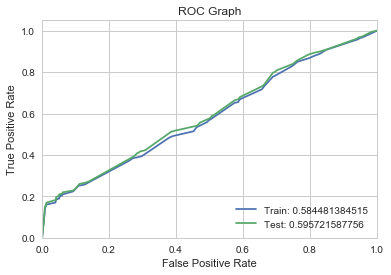

In [89]:
# plotando a curva ROC para as bases de treinamento e validação
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(["Train: " + str(roc_auc1), "Test: " + str(roc_auc2)  ],  loc="lower right")
plt.show()

## Parte_4B: Ajustar, Prever e Validar um modelo de Regressão Logística usando sklearn

In [90]:
X1_train = X_train[['poutcome_success' , 'default_no' , 'job_other' , 'poutcome_failure' , 'marital_single' , 'job_blue_collar' ,
       'job_services' , 'job_technician' , 'marital_divorced']]
X1_test = X_test[['poutcome_success' , 'default_no' , 'job_other' , 'poutcome_failure' , 'marital_single' , 'job_blue_collar' ,
       'job_services' , 'job_technician' , 'marital_divorced']]

model = LogisticRegression()
a = model.fit(X1_train, y_train)

model.fit(X1_train, y_train)
p_train1 = model.predict(X1_train)
p_test1 = model.predict(X1_test)

a.coef_

array([[ 2.75373583,  0.73488319,  0.31672314,  0.47547035,  0.23550844,
        -0.36334137, -0.31591345, -0.10829984, -0.02239958]])

In [91]:
# Calculando confusion matrix, AUC, precision e recall para base de treinamento
#model.fit(Xtrain, Ttrain)
cnf_matrix = confusion_matrix(y_train, p_train1)
print ("\n\n ---Base de Treinamento---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X1_train, y_train)))
# 0,8973811142403936

print ("\n\n ---Logistic Model---")
logit_roc_auc1 = roc_auc_score(y_train, model.predict(X1_train))
print ("Logistic AUC = %2.2f" % logit_roc_auc1)
print(classification_report(y_train, p_train1))



 ---Base de Treinamento---


 ---Matriz de Confusão---
[[28882   366]
 [ 2998   704]]
Accuracy of logistic regression classifier on test set: 0.90


 ---Logistic Model---
Logistic AUC = 0.59
             precision    recall  f1-score   support

          0       0.91      0.99      0.94     29248
          1       0.66      0.19      0.30      3702

avg / total       0.88      0.90      0.87     32950



In [92]:
# Calculando confusion matrix, AUC, precision e recall para base de treinamento
#model.fit(Xtrain, Ttrain)
cnf_matrix1 = confusion_matrix(y_test, p_test1)
print ("\n\n ---Base de Teste---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X1_test, y_test)))
#0,8986112459939788

print ("\n\n ---Logistic Model---")
logit_roc_auc2 = roc_auc_score(y_test, model.predict(X1_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc2)
print(classification_report(y_test, p_test1))



 ---Base de Teste---


 ---Matriz de Confusão---
[[7209   91]
 [ 759  179]]
Accuracy of logistic regression classifier on test set: 0.90


 ---Logistic Model---
Logistic AUC = 0.59
             precision    recall  f1-score   support

          0       0.90      0.99      0.94      7300
          1       0.66      0.19      0.30       938

avg / total       0.88      0.90      0.87      8238



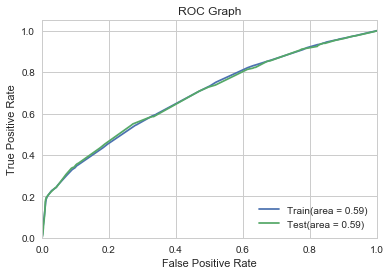

In [93]:
# Plotando o curva ROC para a base de treinamento
fpr1, tpr1, thresholds = roc_curve(y_train, model.predict_proba(X1_train)[:,1])
# fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr1, tpr1, label='Train(area = %0.2f)' % logit_roc_auc1)

# Plotando o curva ROC para a base de teste
fpr2, tpr2, thresholds = roc_curve(y_test, model.predict_proba(X1_test)[:,1])
plt.plot(fpr2, tpr2, label='Test(area = %0.2f)' % logit_roc_auc2)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

Referências <br>
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8